# Tugas Besar 1 IF3270: Feedforward Neural Network (FFNN)

## Import Library

In [1]:
import sys
sys.path.append("../src")

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

from model.ffnn import FFNN
from losses.categorical_crossentropy import loss, derivative
from train.train_loop import train
from utils.visualizer import (
    plot_weight_distribution,
    plot_gradient_distribution,
    visualize_network_structure
)

## 1. Load dan Preprocessing Dataset MNIST

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X.T / 255.0
y = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1)).T

X_train, X_val, y_train, y_val = train_test_split(X.T, y.T, test_size=0.2, random_state=42)
X_train, X_val = X_train.T, X_val.T
y_train, y_val = y_train.T, y_val.T

## 2. Inisialisasi Model FFNN
- Arsitektur: 784 - 128 - 64 - 10
- Aktivasi: ReLU + Softmax
- Inisialisasi: He
- Regularisasi: None

In [3]:
model = FFNN(
    layer_sizes=[784, 128, 64, 10],
    activations=["relu", "relu", "softmax"],
    learning_rate=0.01,
    regularization="none",
    rmsnorm=False,
    init_method="he"
)

## 3. Training Model
- Epoch: 10
- Batch Size: 64

In [4]:
history = train(
    model,
    X_train, y_train,
    X_val, y_val,
    loss_fn=loss,
    loss_deriv=derivative,
    batch_size=64,
    learning_rate=0.01,
    epochs=10,
    verbose=1
)

Epoch 1/10 - Train Loss: 0.779468, Val Loss: 0.397091


Epoch 2/10 - Train Loss: 0.344225, Val Loss: 0.312428


Epoch 3/10 - Train Loss: 0.287545, Val Loss: 0.276915


Epoch 4/10 - Train Loss: 0.256343, Val Loss: 0.253608


Epoch 5/10 - Train Loss: 0.233724, Val Loss: 0.235737


Epoch 6/10 - Train Loss: 0.215610, Val Loss: 0.221317


Epoch 7/10 - Train Loss: 0.200460, Val Loss: 0.209094


Epoch 8/10 - Train Loss: 0.187368, Val Loss: 0.198617


Epoch 9/10 - Train Loss: 0.175867, Val Loss: 0.189534


Epoch 10/10 - Train Loss: 0.165646, Val Loss: 0.181481


## 4. Visualisasi Distribusi Bobot dan Gradien

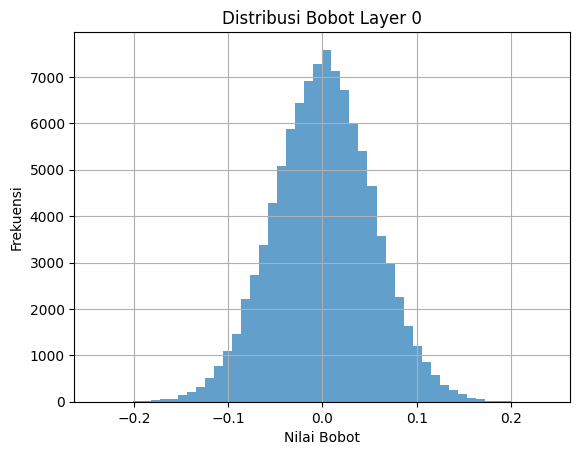

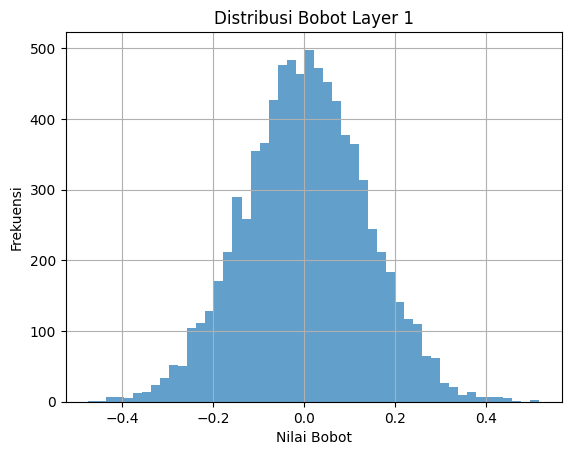

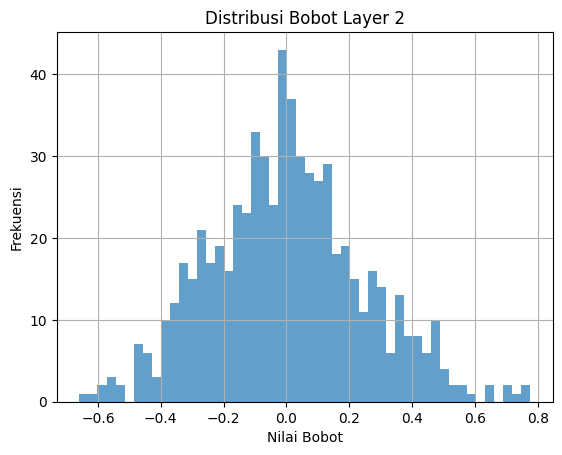

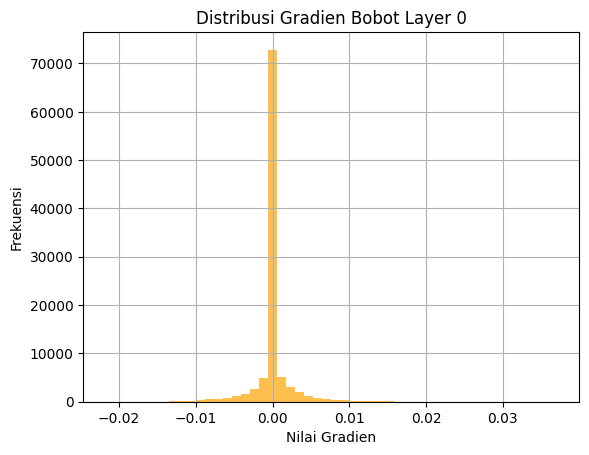

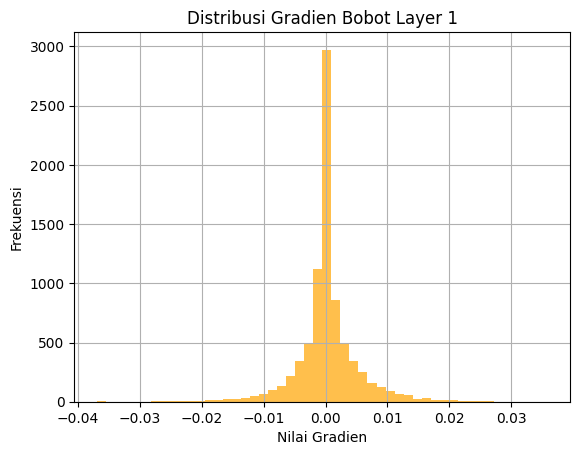

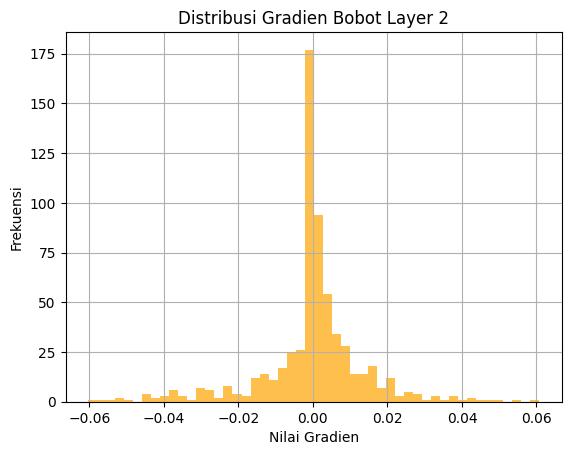

In [5]:
plot_weight_distribution(model)
plot_gradient_distribution(model)

## 5. Visualisasi Struktur Jaringan (Subset Neuron)

c:\Users\Lenovo PC\Project\Custom-FFNN\notebooks\../src\utils\visualizer.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


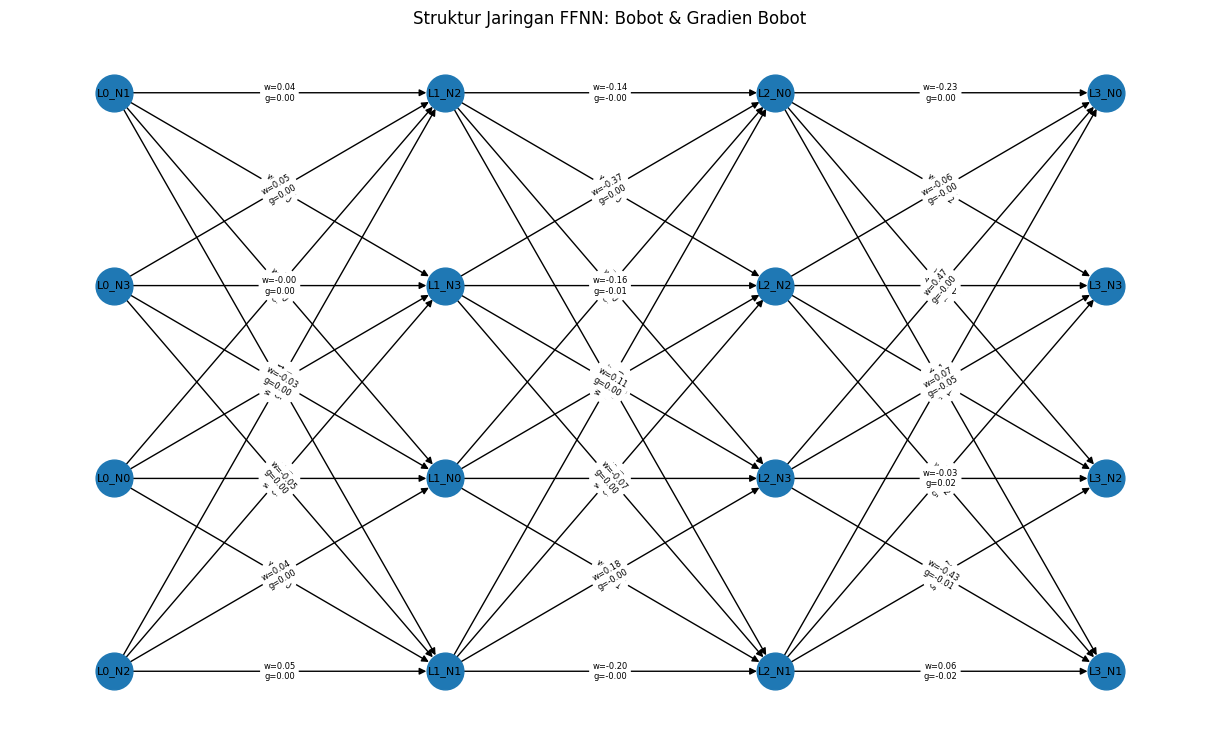

In [6]:
visualize_network_structure(model, max_neurons_per_layer=4)

## 6. Save dan Load Model

In [7]:
model.save("model_trained.pkl")

## 7. Evaluasi dengan MLPClassifier (Sklearn)

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=10)
clf.fit(X_train.T, np.argmax(y_train, axis=0))
y_pred_sklearn = clf.predict(X_val.T)
y_true = np.argmax(y_val, axis=0)

print("Akurasi MLPClassifier sklearn:", accuracy_score(y_true, y_pred_sklearn))

Akurasi MLPClassifier sklearn: 0.9742142857142857


c:\Users\Lenovo PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


## 8. Analisis & Kesimpulan Awal
- FFNN dari scratch dapat dilatih dengan sukses dan stabil.
- Model menghasilkan distribusi bobot/gradien yang dapat divisualisasi.
- Performa FFNN bisa dibandingkan dengan model library seperti Sklearn.

### Fungsi Plotting Perbandingan Loss

In [9]:
def plot_loss_comparison(histories, title):
    plt.figure(figsize=(8, 5))
    for label, val_loss in histories.items():
        plt.plot(val_loss, label=str(label))
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Eksperimen 1: Pengaruh Width (Banyak Neuron per Layer)

- Arsitektur:
  - Width kecil: [784, 32, 10]
  - Width sedang: [784, 64, 10]
  - Width besar: [784, 128, 10]
- Depth tetap = 1 hidden layer
- Tujuan: Melihat pengaruh jumlah neuron terhadap performa dan konvergensi

In [10]:
widths = [32, 64, 128]
histories_width = {}

for width in widths:
    model = FFNN(
        layer_sizes=[784, width, 10],
        activations=["relu", "softmax"],
        learning_rate=0.01,
        init_method="he"
    )
    print(f"Training width={width}")
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_width[width] = history["val_loss"]

Training width=32
Training width=64
Training width=128


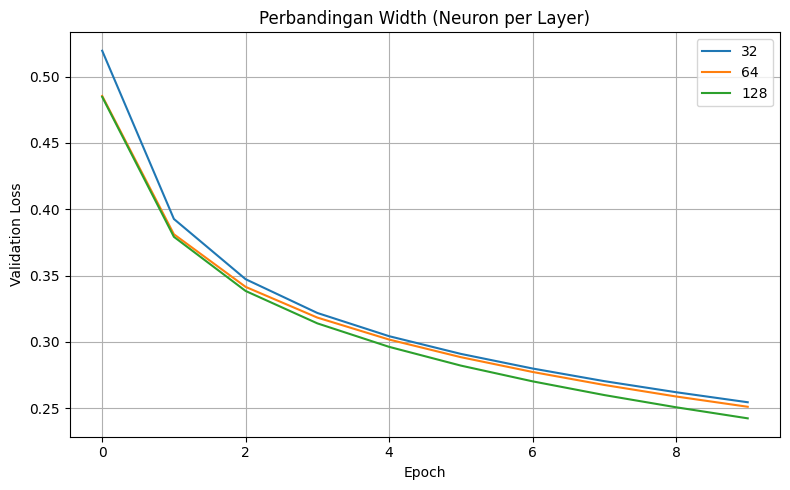

In [11]:
plot_loss_comparison(histories_width, "Perbandingan Width (Neuron per Layer)")

### Eksperimen 2: Pengaruh Depth (Jumlah Hidden Layer)

- Arsitektur:
  - Shallow: 1 hidden layer → [784, 64, 10]
  - Medium: 2 hidden layer → [784, 64, 64, 10]
  - Deep: 3 hidden layer → [784, 64, 64, 64, 10]
- Width tetap = 64
- Tujuan: Melihat pengaruh kedalaman jaringan terhadap performa

In [12]:
depth_configs = {
    "shallow": [784, 64, 10],
    "medium": [784, 64, 64, 10],
    "deep": [784, 64, 64, 64, 10]
}

histories_depth = {}

for name, layers in depth_configs.items():
    model = FFNN(
        layer_sizes=layers,
        activations=["relu"] * (len(layers) - 2) + ["softmax"],
        learning_rate=0.01,
        init_method="he"
    )
    print(f"Training depth={name}")
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_depth[name] = history["val_loss"]

Training depth=shallow
Training depth=medium
Training depth=deep


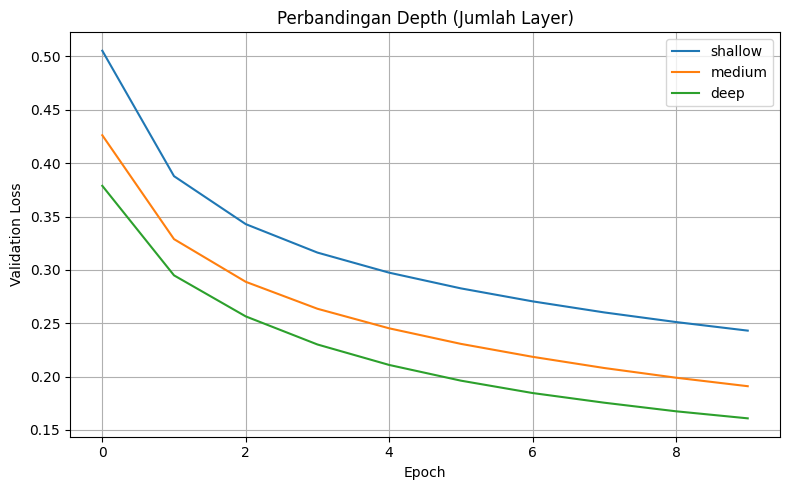

In [13]:
plot_loss_comparison(histories_depth, "Perbandingan Depth (Jumlah Layer)")

### Eksperimen 3: Pengaruh Fungsi Aktivasi pada Hidden Layer

- Fungsi yang diuji: `relu`, `sigmoid`, `tanh`, `swish`, `gelu`
- Hidden layer: 2
- Arsitektur: [784, 64, 64, 10]
- Output layer tetap `softmax`
- Tujuan: Bandingkan loss dan distribusi bobot hasil dari fungsi aktivasi berbeda

In [14]:
activations = ["relu", "sigmoid", "tanh", "swish", "gelu"]
histories_activation = {}

for act in activations:
    print(f"Training with activation: {act}")
    model = FFNN(
        layer_sizes=[784, 64, 64, 10],
        activations=[act, act, "softmax"],
        learning_rate=0.01,
        init_method="he"
    )
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_activation[act] = history["val_loss"]

Training with activation: relu
Training with activation: sigmoid
Training with activation: tanh
Training with activation: swish
Training with activation: gelu


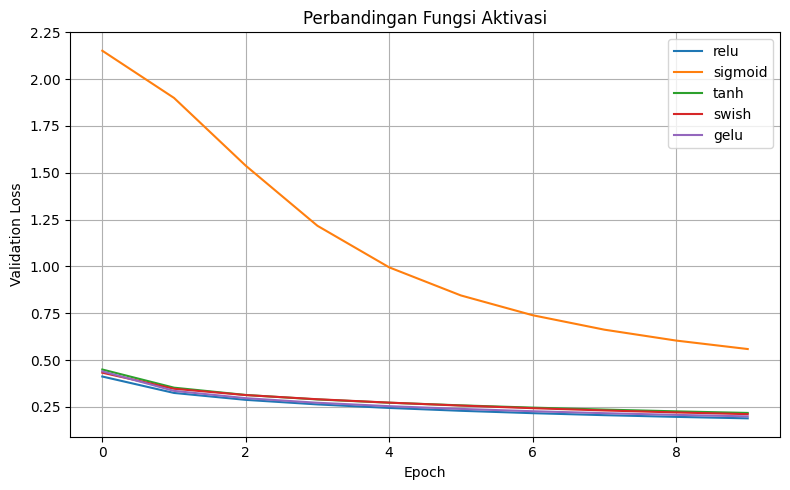

In [15]:
plot_loss_comparison(histories_activation, "Perbandingan Fungsi Aktivasi")

### Eksperimen 4: Pengaruh Learning Rate

- Learning rates: 0.1, 0.01, 0.001
- Arsitektur tetap: [784, 64, 64, 10]
- Aktivasi: ReLU + Softmax

In [16]:
lrs = [0.1, 0.01, 0.001]
histories_lr = {}

for lr in lrs:
    print(f"Training with learning rate: {lr}")
    model = FFNN(
        layer_sizes=[784, 64, 64, 10],
        activations=["relu", "relu", "softmax"],
        learning_rate=lr,
        init_method="he"
    )
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_lr[lr] = history["val_loss"]

Training with learning rate: 0.1
Training with learning rate: 0.01
Training with learning rate: 0.001


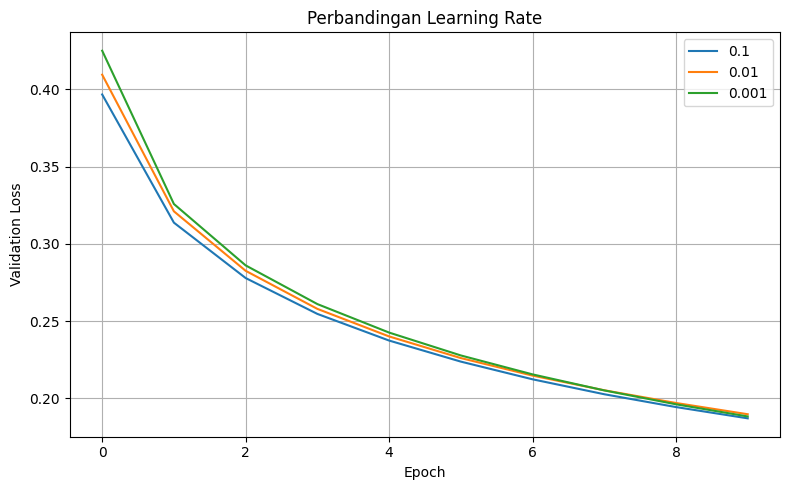

In [17]:
plot_loss_comparison(histories_lr, "Perbandingan Learning Rate")

### Eksperimen 5: Pengaruh Inisialisasi Bobot

- Metode: `zero`, `uniform`, `normal`, `xavier`, `he`
- Arsitektur: [784, 64, 64, 10]
- Aktivasi: ReLU + Softmax

In [18]:
inits = ["zero", "uniform", "normal", "xavier", "he"]
histories_init = {}

for init in inits:
    print(f"Training with init: {init}")
    model = FFNN(
        layer_sizes=[784, 64, 64, 10],
        activations=["relu", "relu", "softmax"],
        learning_rate=0.01,
        init_method=init
    )
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_init[init] = history["val_loss"]

Training with init: zero
Training with init: uniform
Training with init: normal
Training with init: xavier
Training with init: he


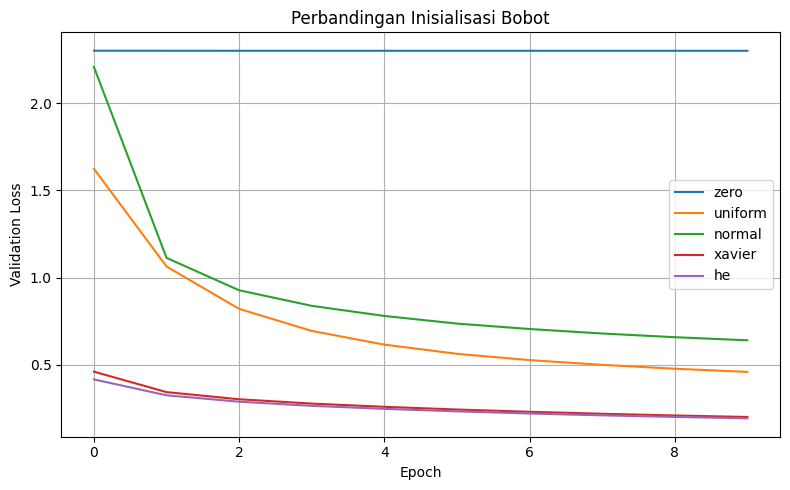

In [19]:
plot_loss_comparison(histories_init, "Perbandingan Inisialisasi Bobot")

### Eksperimen 6: Regularisasi (L1 vs L2 vs None)

- Arsitektur: [784, 64, 64, 10]
- Learning rate: 0.01
- Aktivasi: ReLU

In [20]:
regs = ["none", "l1", "l2"]
histories_reg = {}

for reg in regs:
    print(f"Training with regularization: {reg}")
    model = FFNN(
        layer_sizes=[784, 64, 64, 10],
        activations=["relu", "relu", "softmax"],
        learning_rate=0.01,
        regularization=reg,
        init_method="he"
    )
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_reg[reg] = history["val_loss"]

Training with regularization: none
Training with regularization: l1
Training with regularization: l2


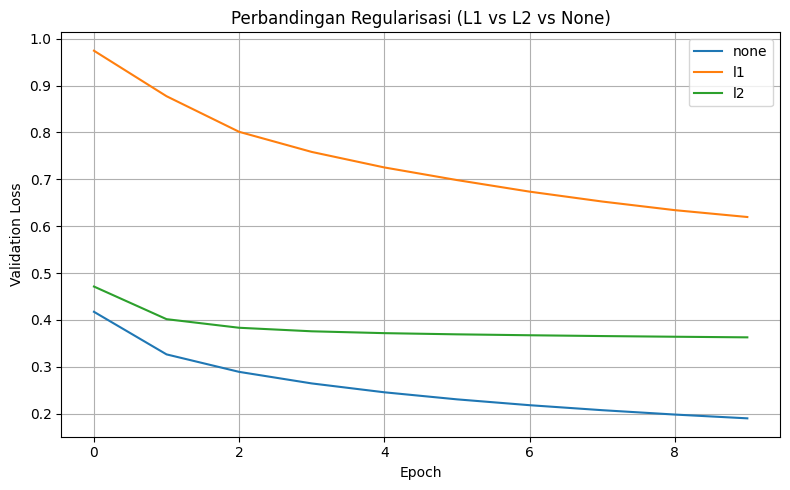

In [21]:
plot_loss_comparison(histories_reg, "Perbandingan Regularisasi (L1 vs L2 vs None)")

### Eksperimen 7: Normalisasi RMSNorm

- Dibandingkan: tanpa normalisasi vs RMSNorm
- Arsitektur: [784, 64, 64, 10]

In [22]:
norm_opts = [False, True]
histories_norm = {}

for norm in norm_opts:
    print(f"Training with RMSNorm={norm}")
    model = FFNN(
        layer_sizes=[784, 64, 64, 10],
        activations=["relu", "relu", "softmax"],
        learning_rate=0.01,
        rmsnorm=norm,
        init_method="he"
    )
    history = train(model, X_train, y_train, X_val, y_val, loss, derivative, epochs=10, batch_size=64, verbose=0)
    histories_norm[str(norm)] = history["val_loss"]

Training with RMSNorm=False
Training with RMSNorm=True


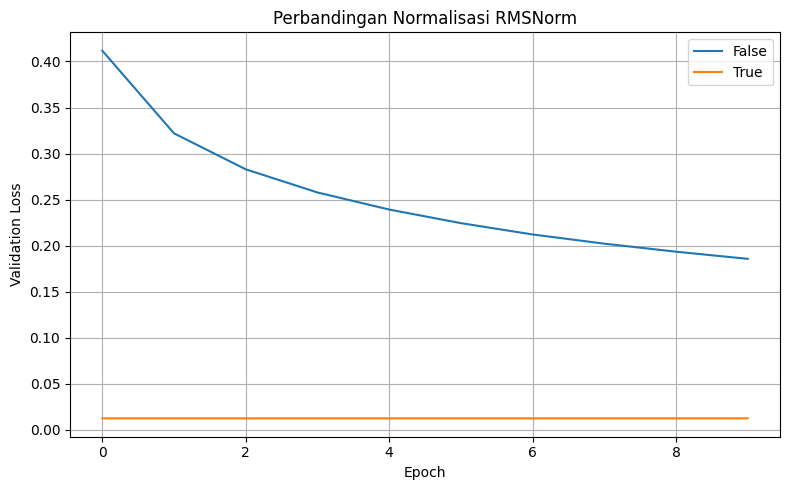

In [23]:
plot_loss_comparison(histories_norm, "Perbandingan Normalisasi RMSNorm")